In [112]:
import time
import torch
import numpy as np
import torchvision
from torch import nn, optim
import matplotlib.pyplot as plt

In [113]:
X = np.load("olivetti_faces.npy")
Y = np.load("olivetti_faces_target.npy")

In [114]:
X.shape

(400, 64, 64)

In [124]:
print(len(np.unique(Y)))

40


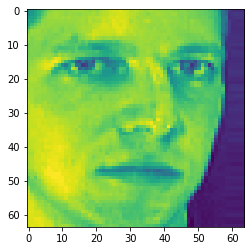

In [118]:
plt.imshow(X[1])

In [142]:
class SmallDataset(torch.utils.data.Dataset):  # 创类：MyDataset,继承torch.utils.data.Dataset
    def __init__(self, image, label, transform=None):
        super(SmallDataset, self).__init__()

        self.imgs = image
        self.labels = label

    def __getitem__(self, index):  # 按照索引读取每个元素的具体内容
        
        img = self.imgs[index]
        label = self.labels[index]
        
        img = torch.FloatTensor(img).unsqueeze(0)
        label = torch.LongTensor([label])[0]
        
        return img, label  # return回哪些内容，在训练时循环读取每个batch，就能获得哪些内容

    def __len__(self):  # 它返回的是数据集的长度，必须有
        return len(self.imgs)
    

In [147]:
#定义VGG各种不同的结构和最后的全连接层结构
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256,'M', 512, 'M', 512,'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'FC':    [2048, 4096, 40]
}

#将数据展开成二维数据，用在全连接层之前和卷积层之后
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

class VGG(nn.Module):
    # nn.Module是一个特殊的nn模块，加载nn.Module，这是为了继承父类
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        # super 加载父类中的__init__()函数
        self.VGG_layer = self.vgg_block(cfg[vgg_name])
        self.FC_layer = self.fc_block(cfg['FC'])
    #前向传播算法
    def forward(self, x):
        out_vgg = self.VGG_layer(x)
        out = out_vgg.view(out_vgg.size(0), -1)
        # 这一步将out拉成out.size(0)的一维向量
        out = self.FC_layer(out_vgg)
        return out
    #VGG模块
    def vgg_block(self, cfg_vgg):
        layers = []
        in_channels = 1
        for out_channels in cfg_vgg:
            if out_channels == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
        return nn.Sequential(*layers)
    #全连接模块
    def fc_block(self, cfg_fc):
        fc_net = nn.Sequential()
        fc_features, fc_hidden_units, fc_output_units = cfg_fc[0:]
        fc_net.add_module("fc", nn.Sequential(
            FlattenLayer(),
            nn.Linear(fc_features, fc_hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, fc_hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, fc_output_units)
        ))
        return fc_net

#测试准确率
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

#模型训练，定义损失函数、优化函数
def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))



In [148]:
net = VGG('VGG16')
print(net)

VGG(
  (VGG_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [150]:
batch_size = 40

train_data = SmallDataset(X, Y)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

lr, num_epochs = 0.001, 10

#使用Adam优化算法替代传统的SGD，能够自适应学习率
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# 判断device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#训练--迭代更新参数
train(net, train_loader, train_loader, batch_size, optimizer, device, num_epochs)

training on  cpu
epoch 1, loss 4.8352, train acc 0.022, test acc 0.025, time 58.6 sec
epoch 2, loss 1.9138, train acc 0.048, test acc 0.025, time 54.0 sec
epoch 3, loss 1.2008, train acc 0.055, test acc 0.025, time 56.9 sec
epoch 4, loss 0.8974, train acc 0.048, test acc 0.025, time 62.2 sec
epoch 5, loss 0.6988, train acc 0.030, test acc 0.025, time 59.5 sec
epoch 6, loss 0.5720, train acc 0.037, test acc 0.048, time 61.9 sec
epoch 7, loss 0.4845, train acc 0.050, test acc 0.072, time 62.5 sec
epoch 8, loss 0.4231, train acc 0.043, test acc 0.043, time 59.5 sec


KeyboardInterrupt: 

In [136]:
# def load_data_fashion_mnist(batch_size, resize=None, root='./'):
#     """Download the fashion mnist dataset and then load into memory."""
#     trans = []
#     trans.append(torchvision.transforms.ToTensor())
#     transform = torchvision.transforms.Compose(trans)
    
#     mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=False, transform=transform)
#     mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=False, transform=transform)
    
#     train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
#     test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

#     return train_iter, test_iter

In [137]:
# a, b = load_data_fashion_mnist(40)

In [141]:
# for data, label in a:
#     print(data.shape)
#     print(label.shape)
#     break

torch.Size([40, 1, 28, 28])
torch.Size([40])
